In [2]:
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
from phaseunwrapping import wrap_function, mle_1d, upsampling_matrix
from phaseunwrapping import build_1d_first_order_grad, build_1d_second_order_grad
from phaseunwrapping import build_2d_first_order_grad

In [64]:

def tikhonov_1d(psi, R, reg_lambda=1.0, weights=None):
    """Given a 1D wrapped phase vector psi, computes the MLE estimator corresponding to the D2 data fidelity term.
    
    psi: the wrapped phase.
    R: regularization operator
    reg_lambda: the regularization parameter (controls strength).
    weights: weighint for the D2 penalty function.

    """

    # Figure out shape
    n = len(psi)

    # Build F matrix
    F = build_1d_first_order_grad(n, boundary="none")

    # Make $\phi_1$
    phi1 = np.zeros(n)
    phi1[0] = psi[0]

    # Build the undersampling matrix
    P = np.eye(n)[1:,:].T

    # Set initial weights
    if weights is None:
        weights = np.ones(F.shape[0])
    else:
        assert len(weights) == len(psi), "psi and weight vector must have same length!"

    # rhs vector
    rhs = P.T @ F.T @ np.diag(weights) @ ( wrap_function(F @ psi) - (F @ phi1) )

    # Q matrix
    Q = P.T @ F.T @ np.diag(weights) @ F @ P   # data fidelity contribution
    Q = Q + reg_lambda*(R.T @ R)

    # Solve system for answer
    phi2 = np.linalg.solve(Q, rhs)

    # Append first entry
    reconstructed_phi = np.zeros(n)
    reconstructed_phi[1:] = phi2
    reconstructed_phi[0] = psi[0]

    return reconstructed_phi
    


In [4]:
def tikhonov_2d(psi, R, reg_lambda=1.0, weights=None):
    """
    Given a 2D wrapped phase matrix psi, computes the MLE estimator corresponding to the D2 data fidelity term.

    psi: the wrapped phase (2D array).
    R: regularization operator for 2D regularization (2D array).
    reg_lambda: the regularization parameter (controls strength).
    weights: weighting for the D2 penalty function.

    """

    # Flatten psi
    psi_flatten = psi.flatten()

    # Figure out shape
    n, m = psi.shape

    # Build first order gradient matrices
    F_x, F_y = build_2d_first_order_grad(n, m, boundary="none")

    # Make phi1
    phi1 = np.zeros(len(psi_flatten))
    phi1[0] = psi_flatten[0]

    # Build the undersampling matrix
    P = np.eye(n * m)[1:, :].T

    # Set initial weights
    if weights is None:
        weights = np.ones(F_x.shape[0])
    else:
        assert len(weights) == n * m, "psi and weight vector must have the same length!"

    # rhs vector
    rhs = P.T @ np.block([F_x.T, F_y.T]) @ np.diag(weights) @ (
            wrap_function(np.block([F_x @ psi_flatten, F_y @ psi_flatten])) - np.block([F_x @ phi1, F_y @ phi1])
        )

    # Q matrix
    Q = P.T @ np.block([F_x.T, F_y.T]) @ np.diag(weights) @ np.block([F_x, F_y]) @ P   # data fidelity contribution
    Q = Q + reg_lambda * (R.T @ R)

    # Solve system for answer
    phi2 = np.linalg.solve(Q, rhs)

    # Reshape the reconstructed phase back to 2D
    reconstructed_phi = phi2.reshape(n, m)


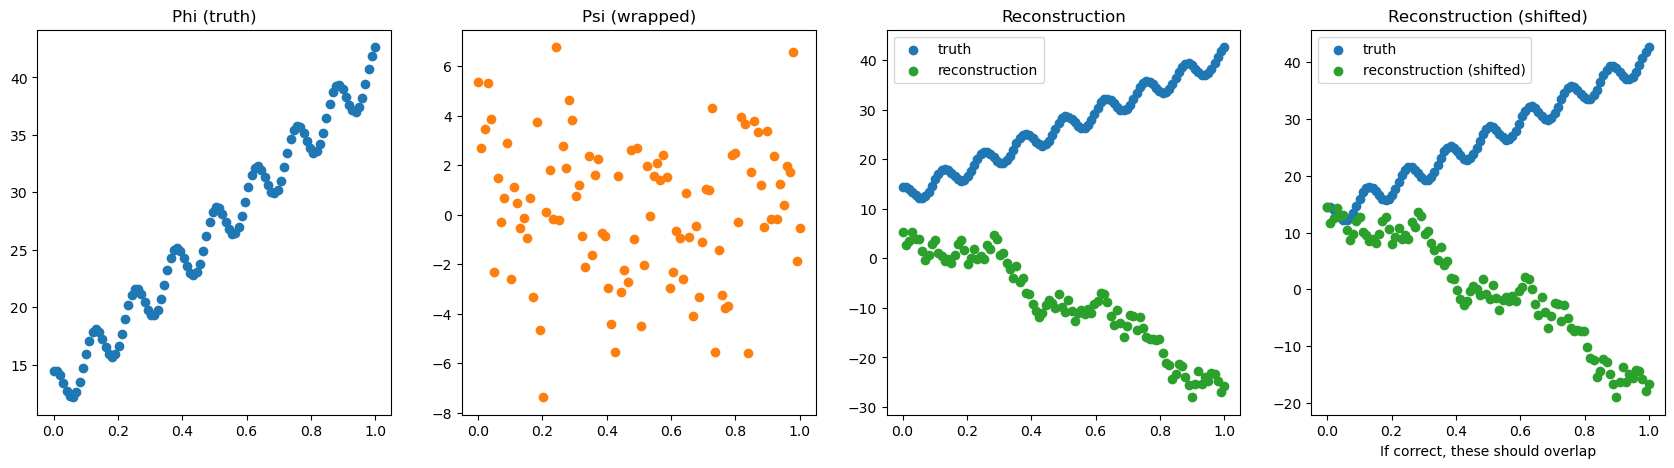

In [90]:
# Make test phase
N = 100
#phi = np.linspace(0, 9*np.pi, N) + (3*np.pi) + 3
# phi[20:] += 2.5
# phi[30:] += 4

phi = np.linspace(0, 9*np.pi, N) + (3*np.pi) + 3
grid = np.linspace(0,1,N)
phi += 2*np.cos( 50*grid )
grid = np.linspace(0,1,N)
noise_sigma = 2

# Wrap it
np.random.seed(0)
psi = wrap_function(phi) + noise_sigma*np.random.normal(size=len(phi))

# Unwrapping algorithm
reconstructed_phi = mle_1d(psi)


# Plot results
fig, axs = plt.subplots(1,4,figsize=(21,5))

axs[0].scatter(grid, phi, color="C0")
axs[1].scatter(grid, psi, color="C1")
axs[0].set_title("Phi (truth)")
axs[1].set_title("Psi (wrapped)")

axs[2].scatter(grid, phi, label="truth", color="C0")
axs[2].scatter(grid, reconstructed_phi, label="reconstruction", color="C2")
axs[2].legend()
axs[2].set_title("Reconstruction")


axs[3].scatter(grid, phi, label="truth", color="C0")
axs[3].scatter(grid, reconstructed_phi + (phi[0] - reconstructed_phi[0]), label="reconstruction (shifted)", color="C2")
axs[3].legend()
axs[3].set_title("Reconstruction (shifted)")
axs[3].set_xlabel("If correct, these should overlap")


plt.show()

In [91]:
#R = np.eye(N-1)
#R = build_1d_first_order_grad(N-1)
R = build_1d_second_order_grad(N-1)

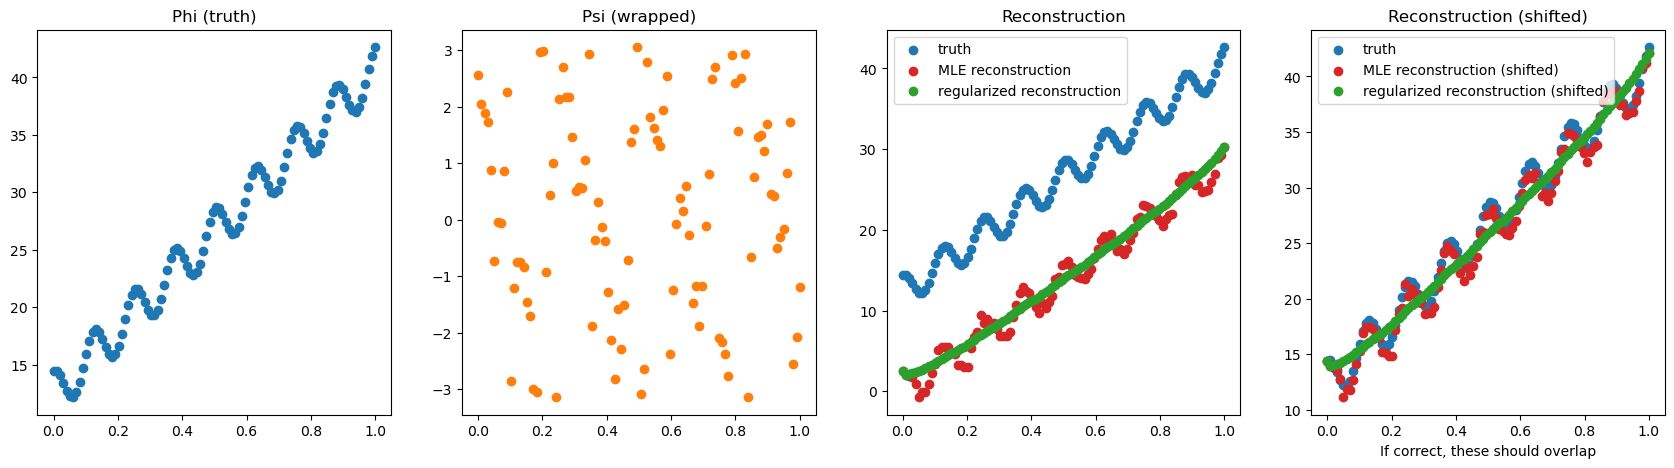

In [93]:
# # Make test phase
# N = 40
# phi = np.linspace(0, 9*np.pi, N) + (3*np.pi) + 3
# # phi[20:] += 2.5
# # phi[30:] += 4
# grid = np.linspace(0,1,N)


N = 100
#phi = np.linspace(0, 9*np.pi, N) + (3*np.pi) + 3
# phi[20:] += 2.5
# phi[30:] += 4

phi = np.linspace(0, 9*np.pi, N) + (3*np.pi) + 3
grid = np.linspace(0,1,N)
phi += 2*np.cos( 50*grid )
grid = np.linspace(0,1,N)
noise_sigma = 2



noise_sigma = 0.4
reg_lambda = 1e2

# Wrap it
np.random.seed(0)
psi = wrap_function(phi + noise_sigma*np.random.normal(size=len(phi)))

# Unwrapping algorithm
mle_phi = mle_1d(psi)
reconstructed_phi = tikhonov_1d(psi, R, reg_lambda=reg_lambda, weights=None)


# Plot results
fig, axs = plt.subplots(1,4,figsize=(21,5))

axs[0].scatter(grid, phi, color="C0")
axs[1].scatter(grid, psi, color="C1")
axs[0].set_title("Phi (truth)")
axs[1].set_title("Psi (wrapped)")


axs[2].scatter(grid, phi, label="truth", color="C0")
axs[2].scatter(grid, mle_phi, label="MLE reconstruction", color="C3")
axs[2].scatter(grid, reconstructed_phi, label="regularized reconstruction", color="C2")
axs[2].legend()
axs[2].set_title("Reconstruction")


axs[3].scatter(grid, phi, label="truth", color="C0")
axs[3].scatter(grid, mle_phi + (phi[0] - mle_phi[0]), label="MLE reconstruction (shifted)", color="C3")
axs[3].scatter(grid, reconstructed_phi + (phi[0] - reconstructed_phi[0]), label="regularized reconstruction (shifted)", color="C2")
axs[3].legend()
axs[3].set_title("Reconstruction (shifted)")
axs[3].set_xlabel("If correct, these should overlap")


plt.show()

# Multiple measurements

In [113]:
J = 100 # number of measurements
measurements = []
np.random.seed(0)
for j in range(J):
    measurement = wrap_function( phi + noise_sigma*np.random.normal(size=len(phi))) 
    measurements.append(measurement)

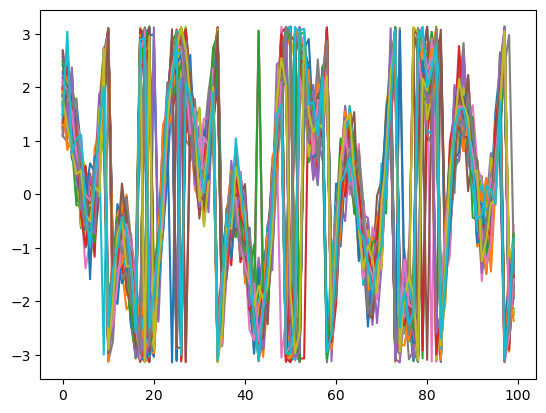

In [114]:
for j in range(J):
    plt.plot(measurements[j])
plt.show()

In [115]:
# import numpy as np
# from scipy.sparse.linalg import aslinearoperator

# from phaseunwrapping import wrap_function, build_1d_first_order_grad
# from phaseunwrapping.util import upsampling_matrix

In [116]:
# import numpy as np
# from scipy.sparse.linalg import aslinearoperator

# from phaseunwrapping import wrap_function, build_1d_first_order_grad, upsampling_matrix
# # from .cg import relative_residual_cg

def multi_mle_1d(psis, weights=None):
    """Given a 1D wrapped phase vector psi, computes the MLE estimator corresponding to the D2 data fidelity term.
    
    psi: the wrapped phase.
    weights: weighint for the D2 penalty function.

    """

    # Figure out shape
    n = len(psis[0])
    J = len(psis)

    # Build F matrix
    F = build_1d_first_order_grad(n, boundary="none")

    # Make $\phi_1$
    phi1 = np.zeros(n)
    phi1[0] = psis[0][0]

    # Build the undersampling matrix
    P = np.eye(n)[1:,:].T

    # Set initial weights
    if weights is None:
        weights = np.ones(F.shape[0])
    else:
        assert len(weights) == len(psis[0]), "psi and weight vector must have same length!"

    # rhs vector
    #rhs = P.T @ F.T @ np.diag(weights) @ ( wrap_function(F @ psi) - (F @ phi1) )
    rhs = np.zeros(P.T.shape[0])
    for j in range(J):
        rhs += P.T @ F.T @ np.diag(weights) @ ( wrap_function(F @ psis[j]) - (F @ phi1) )

    # Q matrix
    Q = J*( P.T @ F.T @ np.diag(weights) @ F @ P  )

    # Solve system for answer
    phi2 = np.linalg.solve(Q, rhs)

    # Append first entry
    reconstructed_phi = np.zeros(n)
    reconstructed_phi[1:] = phi2
    reconstructed_phi[0] = psi[0]

    return reconstructed_phi



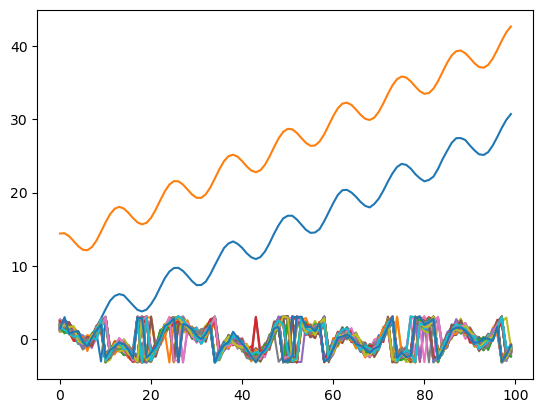

In [117]:
plt.plot(multi_mle_1d(measurements))
for j in range(J):
    plt.plot(measurements[j])
plt.plot(phi)
plt.show()

# Tikhonov regularization with multiple observations

In [118]:
# import numpy as np
# from scipy.sparse.linalg import aslinearoperator

# from phaseunwrapping import wrap_function, build_1d_first_order_grad, upsampling_matrix
# # from .cg import relative_residual_cg

def multi_tikhonov(psis, R, reg_lambda=1.0, weights=None):
    """Given a 1D wrapped phase vector psi, computes the MLE estimator corresponding to the D2 data fidelity term.
    
    psi: the wrapped phase.
    weights: weighint for the D2 penalty function.

    """

    # Figure out shape
    n = len(psis[0])
    J = len(psis)

    # Build F matrix
    F = build_1d_first_order_grad(n, boundary="none")

    # Make $\phi_1$
    phi1 = np.zeros(n)
    phi1[0] = psis[0][0]

    # Build the undersampling matrix
    P = np.eye(n)[1:,:].T

    # Set initial weights
    if weights is None:
        weights = np.ones(F.shape[0])
    else:
        assert len(weights) == len(psis[0]), "psi and weight vector must have same length!"

    # rhs vector
    #rhs = P.T @ F.T @ np.diag(weights) @ ( wrap_function(F @ psi) - (F @ phi1) )
    rhs = np.zeros(P.T.shape[0])
    for j in range(J):
        rhs += P.T @ F.T @ np.diag(weights) @ ( wrap_function(F @ psis[j]) - (F @ phi1) )

    # Q matrix
    Q = J*( P.T @ F.T @ np.diag(weights) @ F @ P  ) + reg_lambda*(R.T @ R)

    # Solve system for answer
    phi2 = np.linalg.solve(Q, rhs)

    # Append first entry
    reconstructed_phi = np.zeros(n)
    reconstructed_phi[1:] = phi2
    reconstructed_phi[0] = psi[0]

    return reconstructed_phi



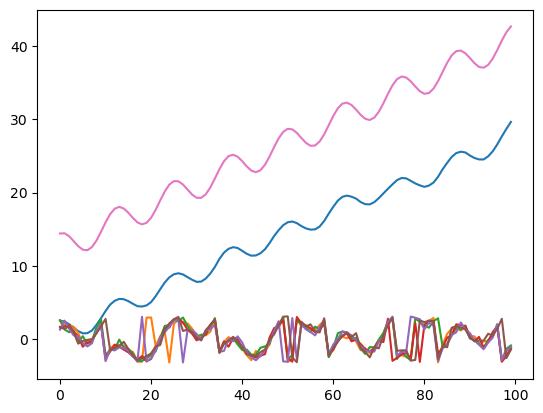

In [112]:
#R = np.eye(N-1)
#R = build_1d_first_order_grad(N-1)
R = build_1d_second_order_grad(N-1)

reg_lambda = 1e1

plt.plot(multi_tikhonov(measurements, reg_lambda=reg_lambda))
for j in range(J):
    plt.plot(measurements[j])
plt.plot(phi)
plt.show()